### Importing Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Loading Data and Preprocessing

In [2]:
raw_data = yfinance.download(tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = '1994-01-07', end = '2019-09-01', 
                              interval = '1d', group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [5]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [6]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']

In [7]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

### Creating Returns

In [21]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.spx.pct_change(1).mul(100)

### Normalizing

In [ ]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp[1]) * 100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp[1]) * 100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp[1]) * 100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp[1]) * 100

### Splitting the Data

In [22]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [24]:
df_test

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,,,,,
Date,,,,,,,,
2014-07-16,1981.569946,9859.269531,6784.700195,15379.299805,0.420108,1.105733,1.438970,0.420108
2014-07-17,1958.119995,9753.879883,6738.299805,15370.259766,-1.183403,-0.683897,-1.068940,-1.183403
2014-07-18,1978.219971,9720.019531,6749.500000,15215.709961,1.026494,0.166217,-0.347148,1.026494
2014-07-21,1973.630005,9612.049805,6728.399902,15215.709961,-0.232025,-0.312617,-1.110797,-0.232025
2014-07-22,1983.530029,9734.330078,6795.299805,15343.280273,0.501615,0.994291,1.272156,0.501615
...,...,...,...,...,...,...,...,...
2019-08-26,2878.379883,11658.040039,7095.000000,20261.039062,1.098299,0.000000,0.400725,1.098299
2019-08-27,2869.159912,11730.019531,7089.600098,20456.080078,-0.320318,-0.076109,0.617424,-0.320318


# Multvariate Regression Model

In [25]:
from statsmodels.tsa.api import VAR

In [41]:
#Endogenous Variables
df_ret = df[['ret_spx','ret_ftse','ret_dax', 'ret_nikkei']][1:]
model_var_ret = VAR(df_ret)
#model_var_ret.select_order(maxlags = 20)
results_var_ret = model_var_ret.fit(2)
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Apr, 2021
Time:                     07:04:25
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -35.1258
Nobs:                     5349.00    HQIC:                  -35.1546
Log likelihood:           63738.8    FPE:                5.31899e-16
AIC:                     -35.1701    Det(Omega_mle):     1.75815e-16
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.036948         0.016142            2.289           0.022
L1.ret_spx           -0.054429              NAN              NAN             NAN
L1.ret_ftse          -0.021326         0.024144           

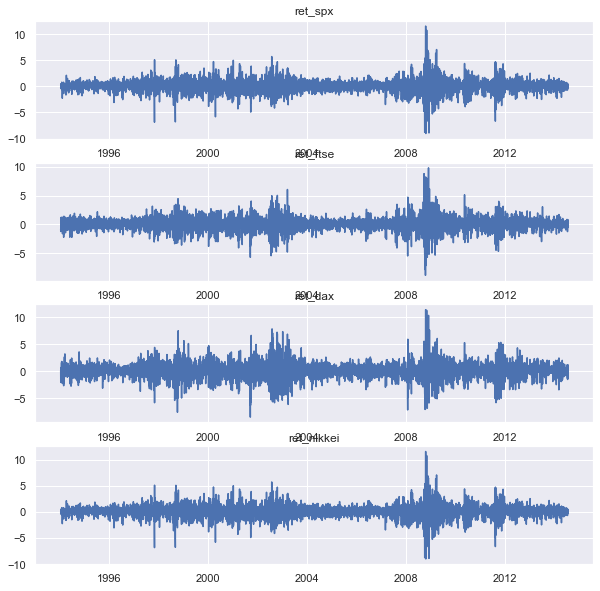

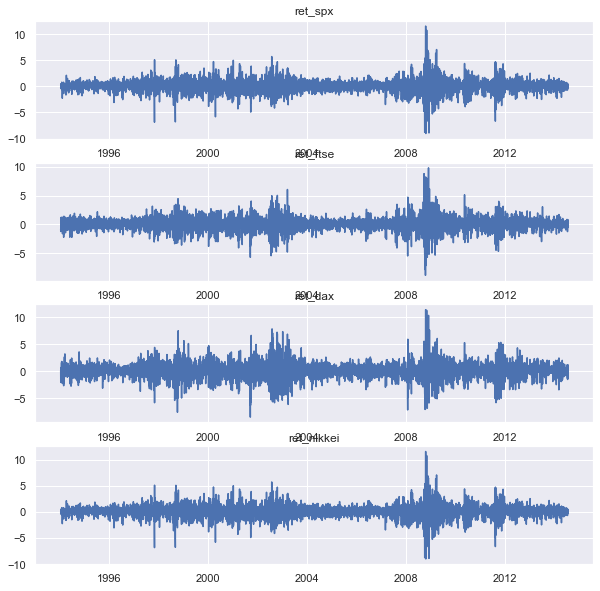

In [33]:
results_var_ret.plot()

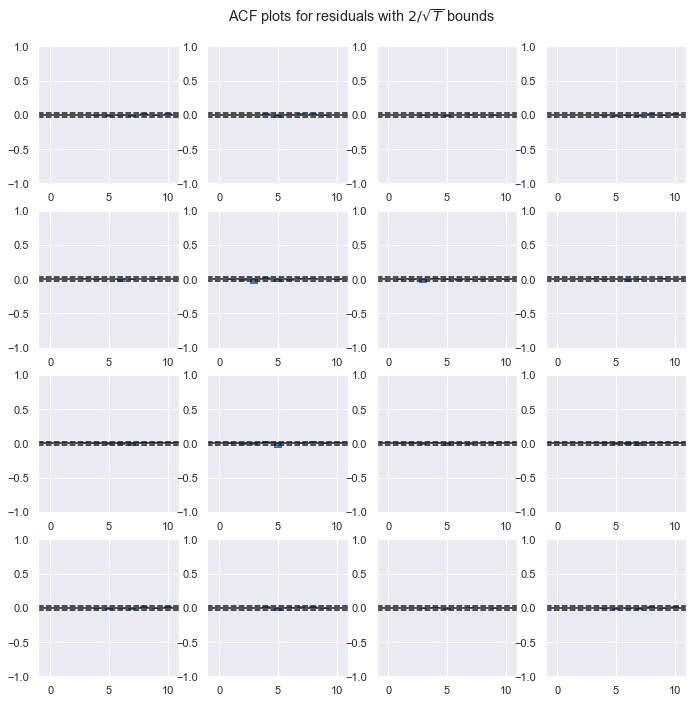

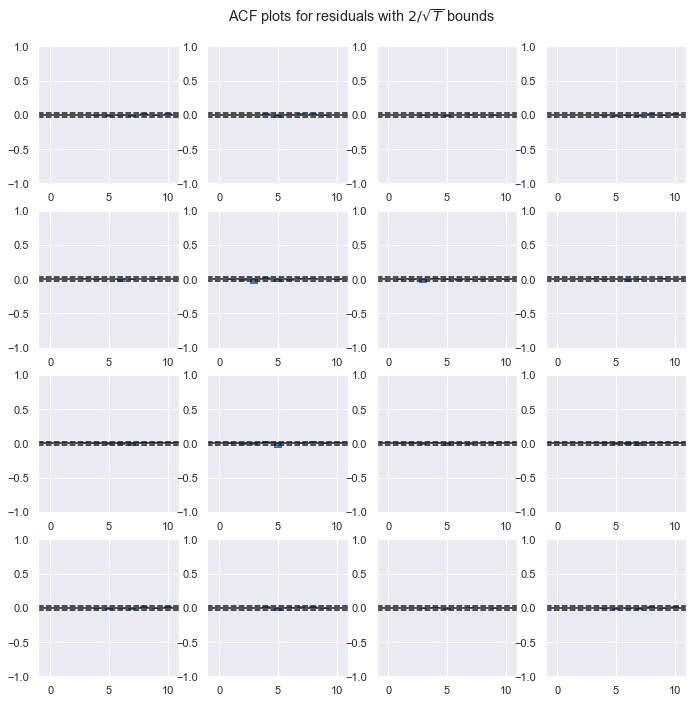

In [35]:
results_var_ret.plot_acorr()

In [43]:
#Predictions
start_date = '2014-07-15'
end_date = '2015-01-01'
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))
df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                          columns = df_test[start_date:end_date].columns[4:])

In [45]:
df_ret_pred

,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,
Date,,,,
2014-07-16,-0.007446,0.030939,0.078392,-0.007446
2014-07-17,0.061333,0.034547,0.044522,0.061333
2014-07-18,0.032839,0.020514,0.039139,0.032839
2014-07-21,0.031985,0.020760,0.040706,0.031985
2014-07-22,0.033968,0.018140,0.037391,0.033968
...,...,...,...,...
2014-12-26,0.033683,0.019429,0.038698,0.033683
2014-12-29,0.033683,0.019429,0.038698,0.033683


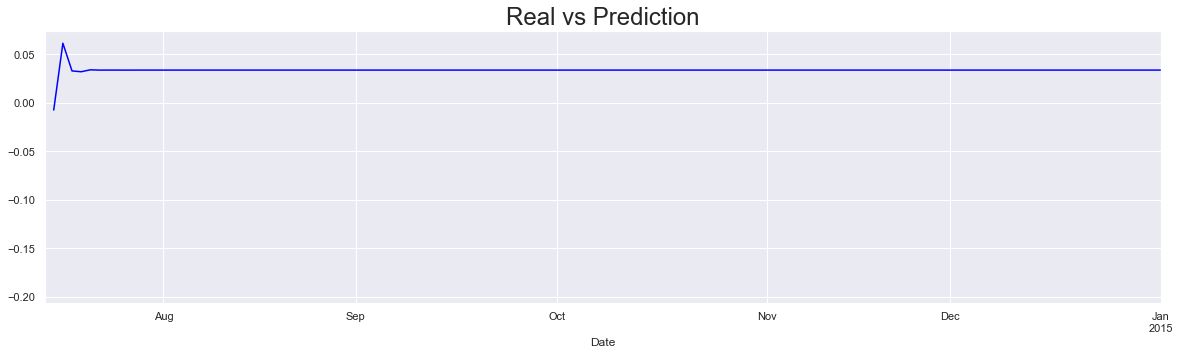

In [50]:
df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5),color = 'blue')
df_ret.ret_nikkei[start_date:end_date].plot(color = 'red')
plt.title('Real vs Prediction', size = 24)
plt.show()

In [51]:
irf = results_var_ret.irf(10)

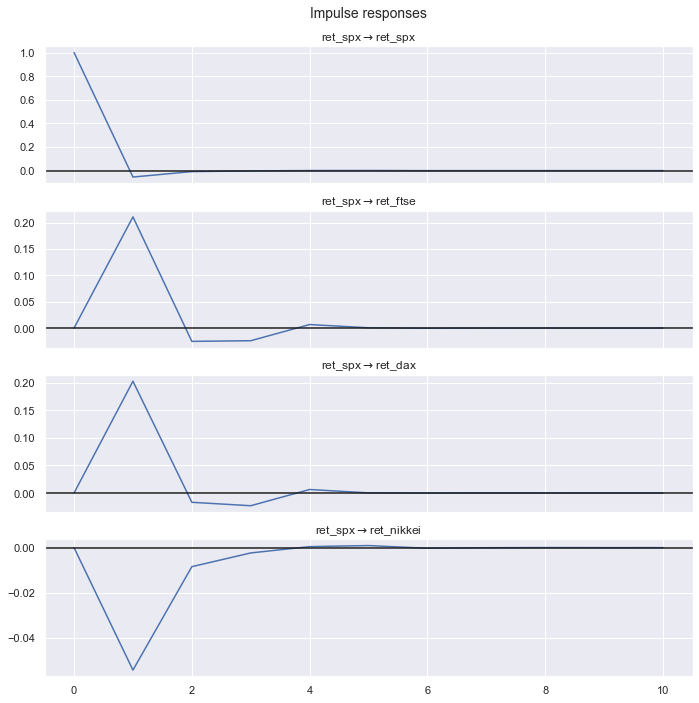

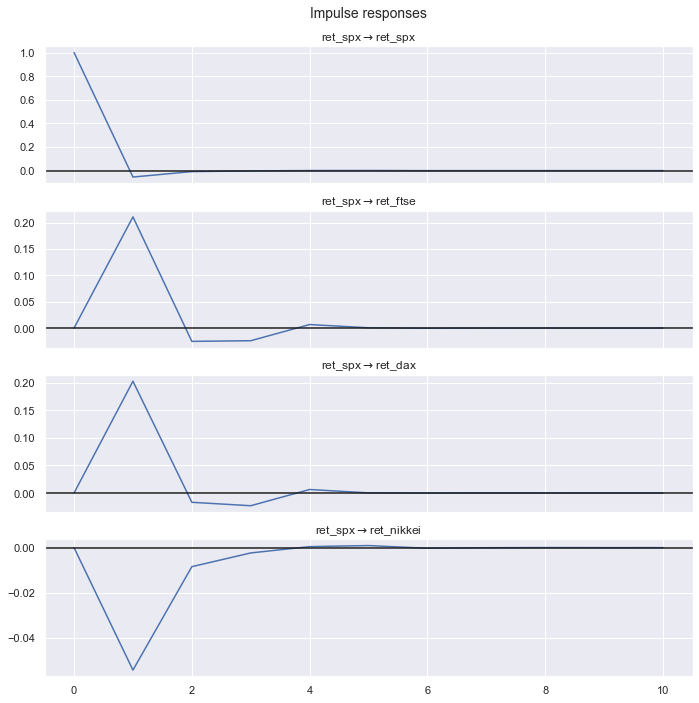

In [60]:
irf.plot(impulse = 'ret_spx')

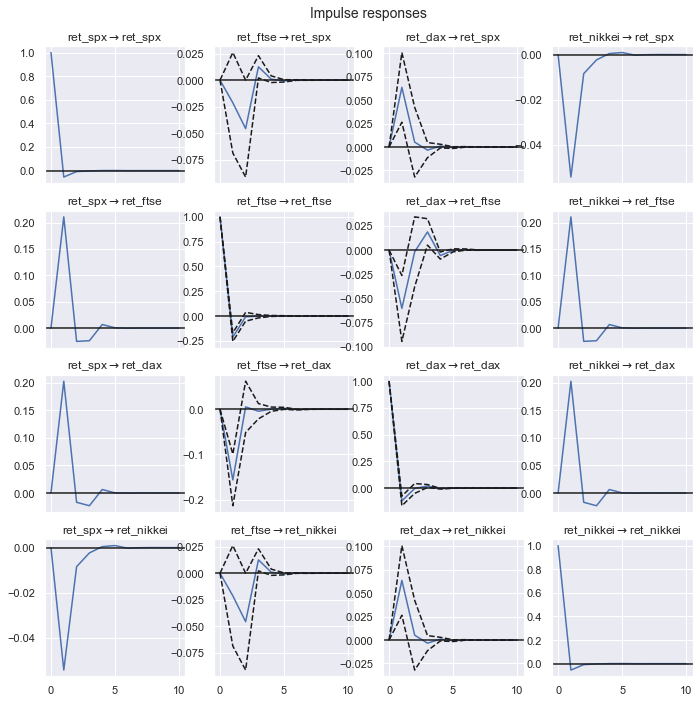

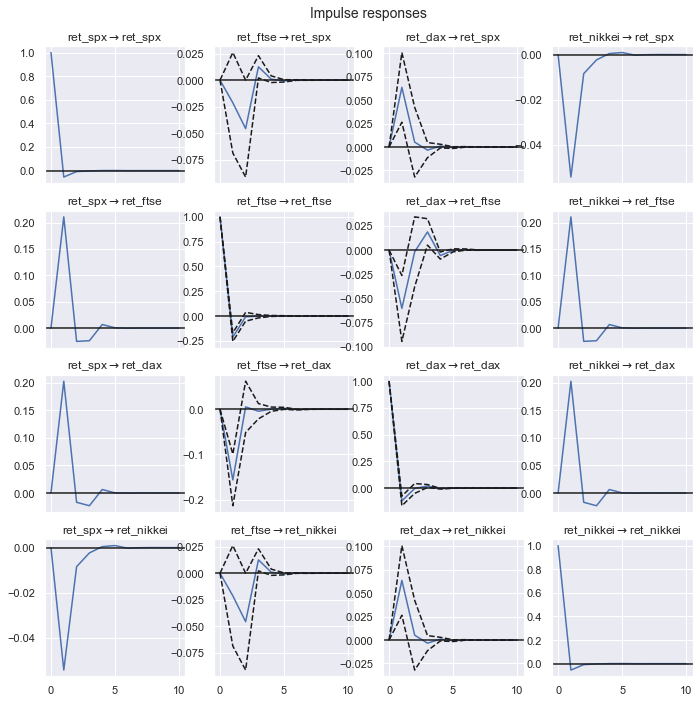

In [52]:
irf.plot(orth = False)

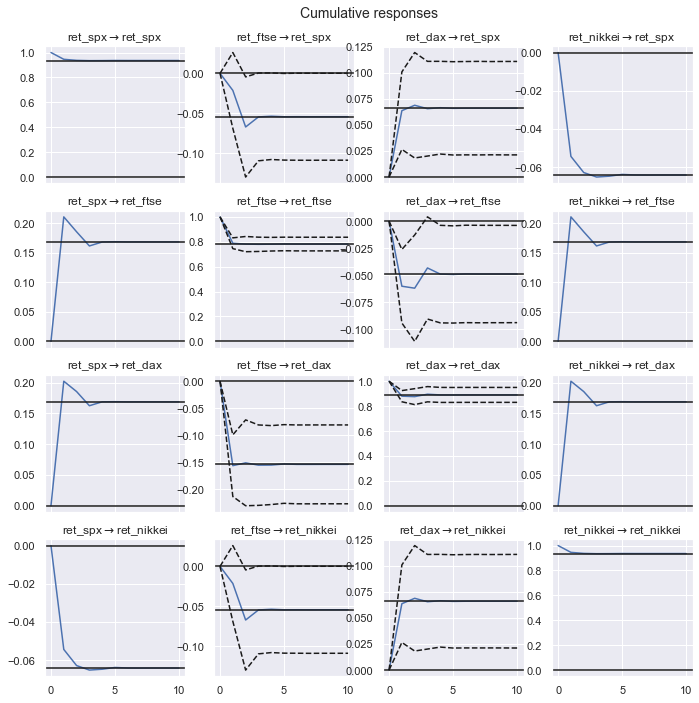

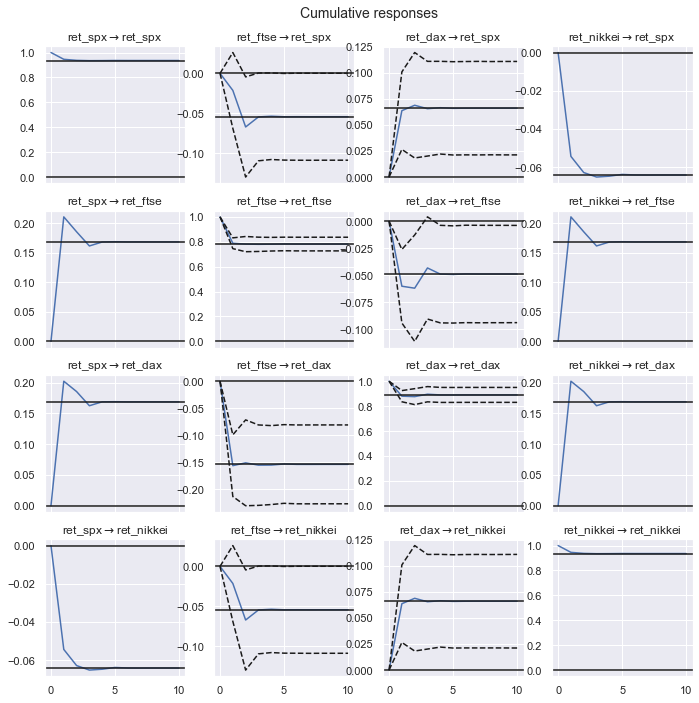

In [54]:
irf.plot_cum_effects(orth = False)

### Forecast Error Variance Decomposition (FEVD)

In [56]:
fevd = results.fevd(5)
fevd.summary()

FEVD for ret_spx
      ret_spx   ret_dax  ret_ftse  ret_nikkei
0    1.000000  0.000000  0.000000    0.000000
1    0.997978  0.001586  0.000436    0.000000
2    0.997901  0.001661  0.000439    0.000000
3    0.997897  0.001664  0.000439    0.000000
4    0.997897  0.001665  0.000439    0.000000

FEVD for ret_dax
      ret_spx   ret_dax  ret_ftse  ret_nikkei
0    0.361980  0.638020  0.000000    0.000000
1    0.376681  0.620719  0.002599    0.000000
2    0.378714  0.618634  0.002653    0.000000
3    0.378868  0.618478  0.002654    0.000000
4    0.378880  0.618467  0.002654    0.000000

FEVD for ret_ftse
      ret_spx   ret_dax  ret_ftse  ret_nikkei
0    0.317004  0.303309  0.379687    0.000000
1    0.357717  0.291866  0.350418    0.000000
2    0.361670  0.291318  0.347012    0.000000
3    0.361952  0.291302  0.346746    0.000000
4    0.361973  0.291302  0.346726    0.000000

FEVD for ret_nikkei
      ret_spx   ret_dax  ret_ftse  ret_nikkei
0    1.000000  0.000000  0.000000    0.000000
1    

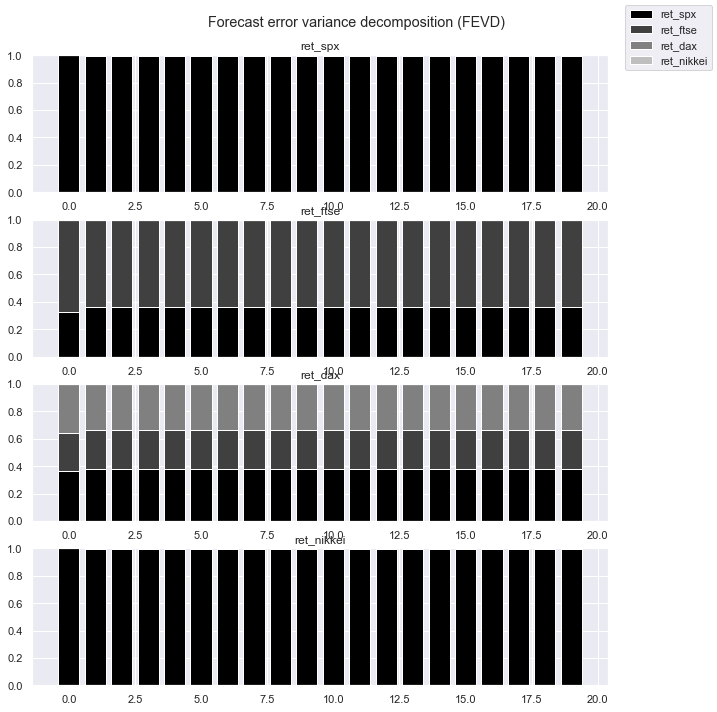

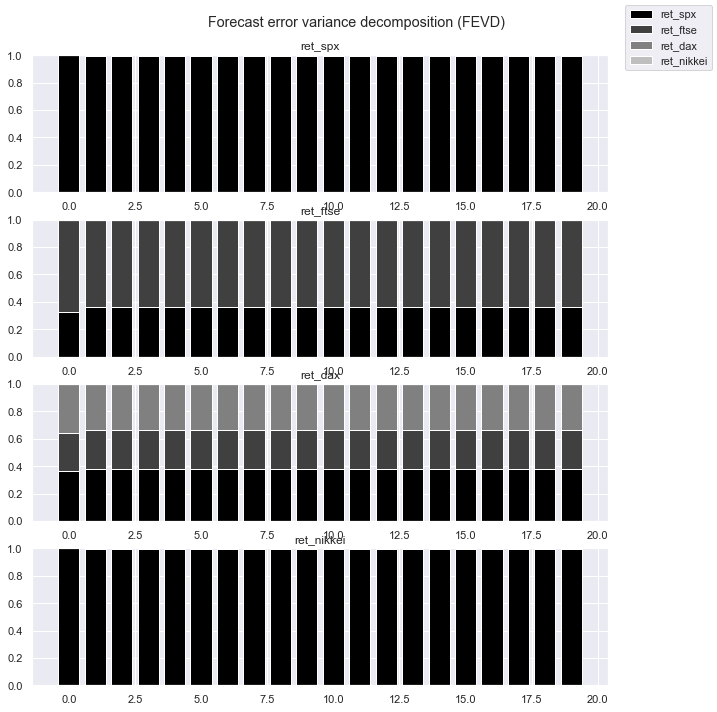

In [57]:
results_var_ret.fevd(20).plot()

### Statistical Tests

In [58]:
#Granger Causality
results_var_ret.test_causality('ret_spx',['ret_ftse', 'ret_nikkei'], kind = 'f')

### Normality

In [59]:
results_var_ret.test_normality()